# Setup

## Imports

In [89]:
from vaiutils import path_consts, plot_images, smooth_plot
from os.path import exists
from scipy.misc import imread, imresize
from glob import glob
import pickle

Keras Modules

In [2]:
import keras.backend as K
from keras.applications.vgg16 import VGG16
from keras.layers import Conv2D, UpSampling2D, BatchNormalization, Activation, Input, Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import Add
from keras.models import Model
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


## Define useful variables and functions

In [3]:
for k, v in path_consts('SuperResolution', ('COCO', 'SampleImages')):
    exec(k + '=v')

In [4]:
def conv_block(x, num_filters=64, kernel_size=3, strides=1, activation='relu', name='conv'):
    if type(strides) is int:
        x = Conv2D(num_filters, kernel_size, strides=(
            strides, strides), padding='same', name=name)(x)
    else:
        strides = int(1/strides)
        x = UpSampling2D((strides, strides), name=name+'_up')(x)
        x = Conv2D(num_filters, kernel_size, padding='same', name=name)(x)

    x = BatchNormalization(name=name + '_bn')(x)
    return Activation(activation, name=name + '_relu')(x) if activation is not None else x

In [5]:
def res_block(x, block_id=None):
    name = 'res_block'
    if block_id is not None:
        name += '_' + str(block_id)

    y = conv_block(x, name=name + '_conv1')
    y = conv_block(y, activation=None, name=name + '_conv2')
    return Add(name=name + '_add')([x, y])

# Prepare Data

In [6]:
generator = ImageDataGenerator()
high_images = generator.flow_from_directory(DIR_DATA['COCO'], (288,288), shuffle=False, batch_size=4)
low_images = generator.flow_from_directory(DIR_DATA['COCO'], (72,72), shuffle=False, batch_size=4)

low_images.batches_per_epoch = int(low_images.samples/low_images.batch_size)

Found 5000 images belonging to 1 classes.
Found 5000 images belonging to 1 classes.


In [7]:
def reset_batches():
    low_images.reset()
    low_images.total_batches_seen=0
    high_images.reset()
    high_images.total_batches_seen=0

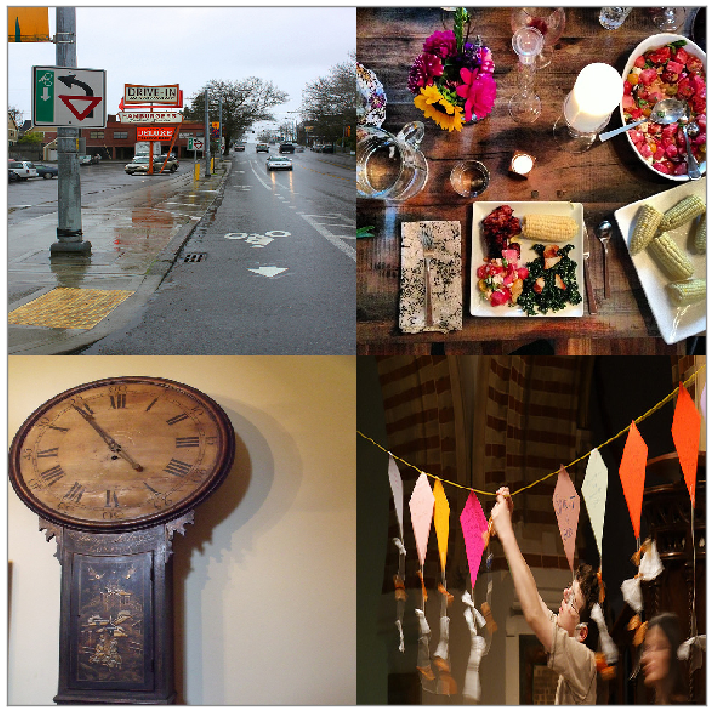

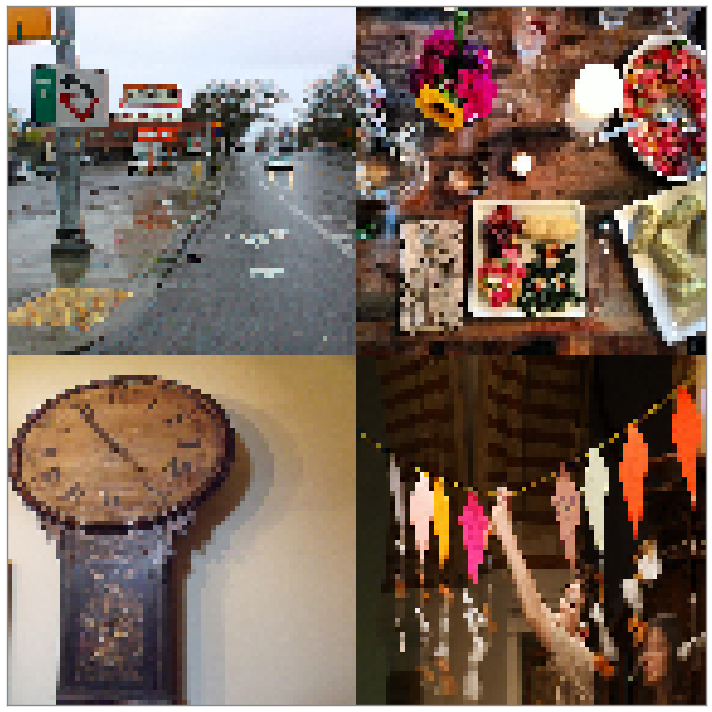

In [8]:
plot_images(high_images.next()[0][:5])
plot_images(low_images.next()[0][:5])
reset_batches()

# Create Models

## Super-resolution Model

In [9]:
def get_model():
    K.clear_session()

    img_input = Input(shape=(72, 72, 3))
    x = conv_block(img_input, kernel_size=9, name='conv1')
    for i in range(4):
        x = res_block(x, i+1)
    for i in range(2):
        x = conv_block(x, strides=1/2, name='tconv'+str(i+1))
    x = conv_block(x, num_filters=3, kernel_size=9, activation='tanh', name='conv2')
    x = Lambda(lambda x: (x+1)*127.5)(x)
    
    model = Model(img_input, x)
    return model

In [68]:
model = get_model()
model.summary(150)

______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             (None, 72, 72, 3)                0                                                                   
______________________________________________________________________________________________________________________________________________________
conv1 (Conv2D)                                   (None, 72, 72, 64)               15616             input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv1_bn (BatchNormalization)                    (None, 72, 72, 64)               256         

## VGG Model

In [11]:
vgg_mean = np.array([123.68,116.779,103.939])
preprocess_input = lambda x: (x-vgg_mean)[:,:,:,::-1]

In [69]:
vgg = VGG16(include_top=False, input_tensor=Lambda(
    preprocess_input)(Input((256, 256, 3))))
vgg = Model(vgg.input, [vgg.get_layer(
    'block{}_conv2'.format(str(i))).output for i in range(2, 6)])
for layer in vgg.layers:
    layer.trainable = False
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
__________

## Custom Loss Model

In [70]:
low_input=Input((72,72,3), name='low_input')
high_input=Input((288,288,3), name='high_input')
pred_output=model(low_input)

high_activations=vgg(high_input)
pred_activations=vgg(pred_output)

activation_importance=[1, 0, 0, 0]
def perceptual_loss(activation_list):
    x_list = activation_list[:len(activation_importance)]
    y_list = activation_list[len(activation_importance):]
    loss = 0

    for x, y, w in zip(x_list, y_list, activation_importance):
        diff = x - y
        dims = list(range(1, K.ndim(diff)))
        loss += K.expand_dims(K.sqrt(K.mean(diff**2, dims))) * w
    return loss

def tv_loss(x):
    a = K.square(x[:, :287, :287, :] - x[:, 1:, :287, :])
    b = K.square(x[:, :287, :287, :] - x[:, :287, 1:, :])
    return K.sum(K.pow(a + b, 1.25), axis=[1, 2, 3]) * 1e-6

perceptual_loss = Lambda(perceptual_loss, name='perceptual_loss')(
    high_activations + pred_activations)
variation_loss = Lambda(tv_loss, name='variation_loss')(pred_output)
loss_output = Add()([perceptual_loss, variation_loss])

trainer_net=Model([low_input, high_input], perceptual_loss)
trainer_net.compile('adam','mae')
trainer_net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
low_input (InputLayer)           (None, 72, 72, 3)     0                                            
____________________________________________________________________________________________________
high_input (InputLayer)          (None, 288, 288, 3)   0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 288, 288, 3)   403279      low_input[0][0]                  
____________________________________________________________________________________________________
model_2 (Model)                  multiple              12354880    high_input[0][0]                 
                                                                   model_1[1][0]           

In [71]:
if exists(DIR_OUTPUT+'/history.dat'):
    with open(DIR_OUTPUT+'/history.dat', 'rb') as f:
        history = pickle.load(f)
else:
    history = {}

# Train Model

We need a custom generator

In [15]:
def img_generator():
    while True:
        l_img = low_images.next()[0]
        if len(l_img) != low_images.batch_size:
            reset_batches()
            yield([low_images.next()[0], high_images.next()[0]], np.zeros((low_images.batch_size,1)))
        else:
            yield([l_img, high_images.next()[0]], np.zeros((low_images.batch_size,1)))

In [16]:
def fit_trainer(history=None, epochs=1, lr=1e-3):
    trainer_net.optimizer.lr=lr
    
    if exists(DIR_OUTPUT+'/weights.h5'):
        trainer_net.load_weights(DIR_OUTPUT+'/weights.h5')
    
    hist = trainer_net.fit_generator(img_generator(), low_images.batches_per_epoch, epochs=epochs,verbose=0,callbacks=[TQDMNotebookCallback()])
    
    trainer_net.save_weights(DIR_OUTPUT+'/weights.h5')
    
    if history is not None:
        for k, v in hist.history.items():
            if k not in history.keys():
                history[k] = []
            history[k] += hist.history[k]

In [77]:
fit_trainer(history, 3, lr=1e-3)

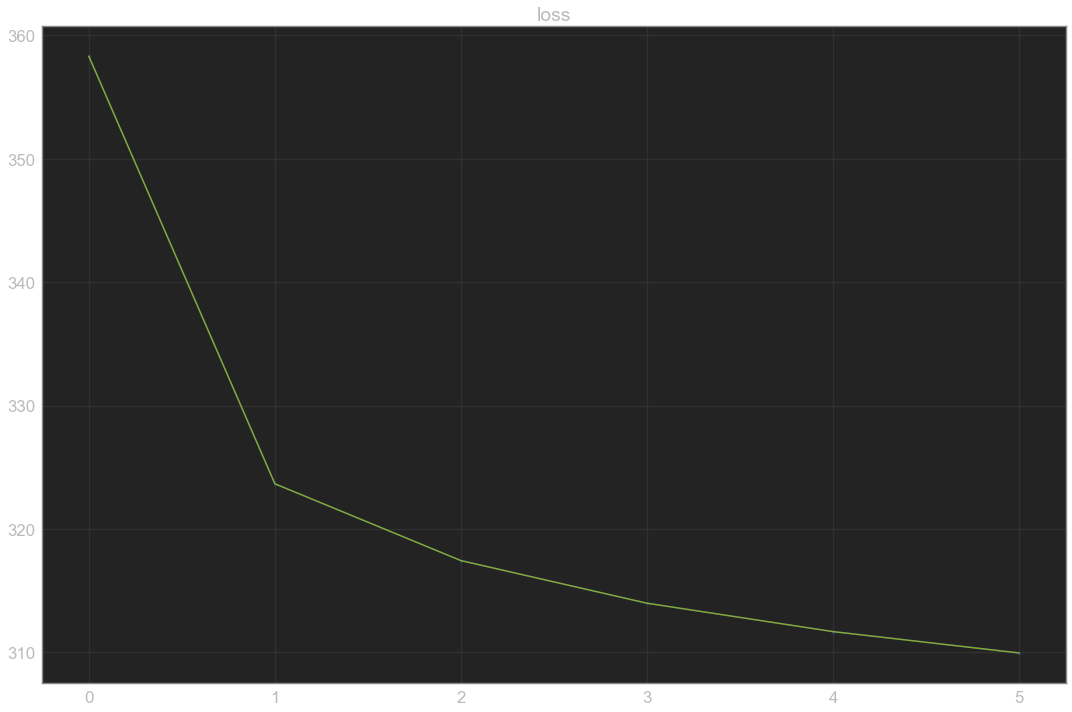

In [78]:
smooth_plot(history, remove_outlier=False)

In [79]:
with open(DIR_OUTPUT+'/history.dat','wb') as f:
    pickle.dump(history, f)

# Test Model

In [90]:
filenames = glob(DIR_DATA['COCO']+'/val2017/*.jpg')

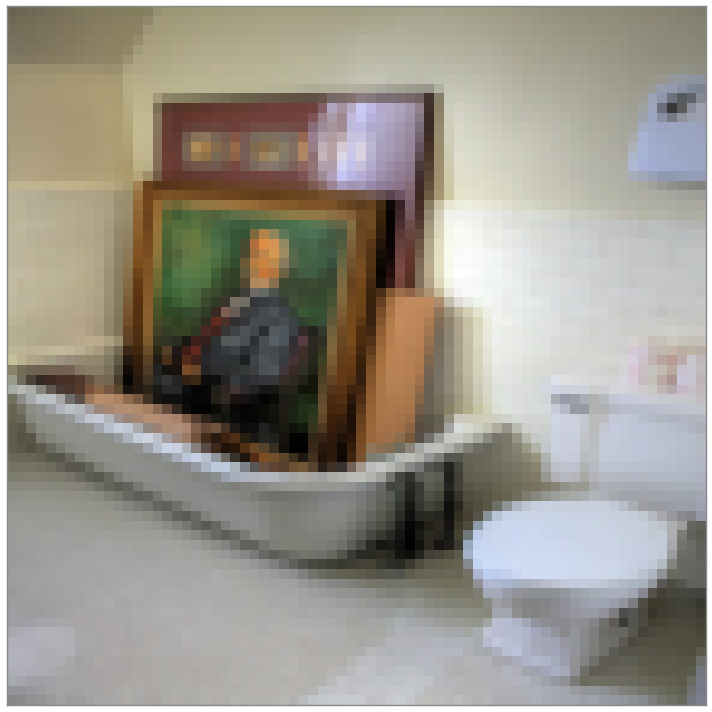

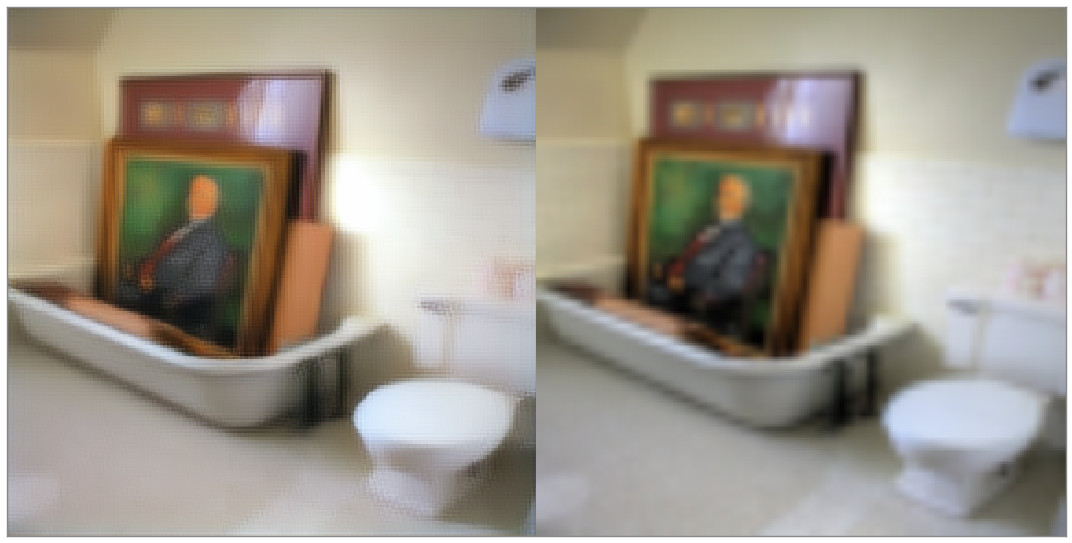

In [130]:
sample_img = imread(filenames[randint(0, 5000)])
plot_images([imresize(sample_img,(72,72,3))])
plot_images([model.predict(np.expand_dims(imresize(sample_img,(72,72,3)),0))[0], imresize(imresize(sample_img,(72,72,3)),(288,288,3))])